# Regressão

A tarefa de **regressão** consiste em predizer **valores** para determinados **objetos**. Vamos contextualizar de maneira operacional esses objetos e valores através de seus tipos de variáveis: em geral um valor é um número real <code>(float)</code> ou um inteiro <code>(int)</code>; já o objeto a ser regredido pode ser um **vetor de features** - aqui vetor tem o mesmo sentido de uma variável lista <code>(lst)</code> ou uma tupla <code>(tuple)</code>. 

Diferentes **algoritmos de regressão** podem ser usados para realizar essa tarefa de, dada uma entrada, gerar uma saída (valor predito para aquele objeto).

Define-se a regressão como uma tarefa de **aprendizado de máquina supervisionado**, isto é, os algoritmos de regressão precisam ser treinados com pares objeto-valor tidos como associações corretas. Somente após o treinamento é que o algoritmo de regressão estará apto a predizer valores para novas entradas (das quais não se sabe o valor a princípio) - diz-se que  algoritmo aprendeu o padrão nos dados de treinamento e agora pode ser usado para predizr o valor de saída para novas entradas.

-----------------------------------------------

In [ ]:
# No google colab é preciso atualizar a versão do matplotlib para gerar alguns detalhes nos gráficos
#!pip install matplotlib --upgrade 

## 1 - IArpi Data Set

#### Descrição geral:
Três diferentes objetos são postos a se mover em um plano inclinado devido a ação da gravidade. Atributos cinemáticos do movimento dos corpos são coletados. Pretende-se estabelecer uma relação entre esses atributos e cada tipo de objeto.

#### Objetivo:
O problema consiste na predição da velocidade média de três objetos (esfera, cilindro e aro) a partir da sua altura inicial em um plano inclinado a um determinado ângulo. O objetivo é introduzir técnicas de IA para cursos de graduação de física onde o experimento do plano inclinado é amplamente estudado (de maneira teórica e em laboratório).


#### Features (variáveis de entrada):
As features foram determinadas experimentalmente:
- Ângulo: ângulo de inclinação do plano [°]
- Altura: de partida do objeto [m]
- Tipo de objeto (esfera, cilindro, aro)

#### Alvo (valor de saída):
- Velocidade Média: velocidade média determinada pela distância/tempo [m/s]

#### Referências:
- https://github.com/simcomat/IArpi
- Ferreira, H., Almeida Junior, E. F., Espinosa-García, W., Novais, E., Rodrigues, J. N. B., & Dalpian, G. M. (2022). Introduzindo aprendizado de máquina em cursos de física: o caso do rolamento no plano inclinado. In Revista Brasileira de Ensino de Física (Vol. 44). FapUNIFESP (SciELO). https://doi.org/10.1590/1806-9126-rbef-2022-0214 

In [1]:
import pandas as pd # Para trabalhar com dados na forma de tabela
import numpy as np  # Para trabalhar com vetores e matrizes

from sklearn.model_selection import train_test_split   # Separação treino/teste
from sklearn.preprocessing import MinMaxScaler         # Escalonador

# Algoritmos de Regressão
from sklearn.linear_model import LinearRegression      # Regressao Linear
from sklearn.svm import SVR                            # Regressão por Máquina de Vetor Suporte
from sklearn.tree import DecisionTreeRegressor         # Regressão por Árvore de Decisão
from sklearn.neighbors import KNeighborsRegressor      # k-vizinhos mais próximos (KNN)
from sklearn.ensemble import RandomForestRegressor     # RandomForest
from sklearn.ensemble import GradientBoostingRegressor # GradientBoosting
from sklearn.neural_network import MLPRegressor        # Multilayer Perceptron

# Valicadao cruzada
from sklearn.model_selection import KFold            # Para separar os dados em k folds na regressao
from sklearn.model_selection import cross_validate   # Para rodar treinamento e teste sobre kfolds
from sklearn import preprocessing          # Auxilia na transformação dos dados (passo 3)
from sklearn.pipeline import make_pipeline # Permite realizar uma sequência de processamentos

# Métricas de desempenho
from sklearn.metrics import mean_absolute_error, r2_score       # Métricas de Regressão
from sklearn.metrics import make_scorer


# Módulos para plotar gráficos e ajustar formatação dos mesmos
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D
import seaborn as sns

### 1 - Primeiro passo: carregando os dados

In [45]:
tabela_dados = pd.read_csv('https://raw.githubusercontent.com/simcomat/IArpi/main/datasets/rolling.csv', sep=';') 

In [46]:
tabela_dados.head()

,Objeto,Ângulo (°),Distancia (m),Altura (m),Tempo (s),Velocidade Média (m/s)
0,esfera,7.73,1.0,0.134505,1.33,0.751880
1,esfera,7.73,1.0,0.134505,1.49,0.671141
2,esfera,7.73,1.0,0.134505,1.49,0.671141
3,esfera,7.73,1.0,0.134505,1.40,0.714286
4,esfera,7.73,1.0,0.134505,1.31,0.763359


In [47]:
tabela_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Objeto                  803 non-null    object 
 1   Ângulo (°)              803 non-null    float64
 2   Distancia (m)           803 non-null    float64
 3   Altura (m)              803 non-null    float64
 4   Tempo (s)               803 non-null    float64
 5   Velocidade Média (m/s)  803 non-null    float64
dtypes: float64(5), object(1)
memory usage: 37.8+ KB


### 1 - Segundo passo: separação de dados

Os algoritmos de regressão não estão preparados para receber um nome (string) como entrada. Então, apenas fornecer o nome do objeto (esfera, cilindro, aro) para o modelo não irá funcionar. Precisamos primeiro converter esses nomes em uma representação numérica. Para isso vamos usar o **OneHot Encoding**. Nessa representação, cada valor do atributo objeto torna-se uma característica única (feature). Para 3 valores de objetos teremos 3 novas colunas com valores binários (verdadeiro ou falso, 1 ou 0) representando cada objeto, por exemplo, se seguirmos (esfera, cilindro, aro) uma esfera será representada pela tupla (1,0,0) enquanto um aro será por (0,0,1). Fisicamente, misturas não seriam possiveis como uma esfera-aro (1,0,1), mas em outras situações essa técnica pode ser usada para representar a presença de mais um objeto (como duas palavras diferentes em uma mesma frase).

In [48]:
ohe = pd.get_dummies(tabela_dados.Objeto, prefix='objeto') # One hot encoding
tabela_dados = tabela_dados.join(ohe)

In [49]:
tabela_dados.head()

,Objeto,Ângulo (°),Distancia (m),Altura (m),Tempo (s),Velocidade Média (m/s),objeto_aro,objeto_cilindro,objeto_esfera
0,esfera,7.73,1.0,0.134505,1.33,0.751880,0,0,1
1,esfera,7.73,1.0,0.134505,1.49,0.671141,0,0,1
2,esfera,7.73,1.0,0.134505,1.49,0.671141,0,0,1
3,esfera,7.73,1.0,0.134505,1.40,0.714286,0,0,1
4,esfera,7.73,1.0,0.134505,1.31,0.763359,0,0,1


In [50]:
x = tabela_dados[['Altura (m)','Ângulo (°)', 'objeto_aro', 'objeto_cilindro','objeto_esfera']] 
y = tabela_dados['Velocidade Média (m/s)'] # Atributo alvo

# Dividindo conjunto de treinamento e conjunto de teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42)

### 1 - Terceiro passo: transformação dos dados

**OBS:** perceba que nem sempre a transformação ocorre apenas no terceiro passo. Tivemos que fazer uma transformação usando o One Hot Encoding (OHE) no segundo passo. A troca da ordem neste caso foi feita para facilitar a etapa de separação (não ter que filtrar a coluna objeto após transformar via OHE.

In [51]:
scaler = MinMaxScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

### 1 - Quarto passo: treinando os algoritmos de regressão

In [52]:
# Regressao Linear
lr = LinearRegression()
lr.fit(x_train_scaled,y_train)

# KNN Regressor
knnr = KNeighborsRegressor()
knnr.fit(x_train_scaled,y_train)

# SVM
svmr = SVR()
svmr.fit(x_train_scaled,y_train)

# Regressão por Árvore de Decisão
dtr = DecisionTreeRegressor()
dtr.fit(x_train_scaled,y_train)

# Regressão por Random
rfr = RandomForestRegressor(random_state=42)
rfr.fit(x_train_scaled, y_train)

# Regressõ por GB
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(x_train_scaled, y_train)

# Multilayer Perceptron
mlpr =  MLPRegressor(random_state=42)
mlpr.fit(x_train_scaled,y_train)

regressores = {
    'LR':lr,
    'KNNR':knnr,
    'SVMR':svmr,
    'RFR':rfr,
    'GBR':gbr,
    'MLPR':mlpr,
}

### 1 - Quinto passo: avaliar o desempenho

In [53]:
resultados={}
resultados_MAE={}
resultados_R2={}

for rg_name, rg in regressores.items():
    
    y_pred = rg.predict(x_test_scaled)        # Entrando os dados de teste no modelo ML
    mae = mean_absolute_error(y_test, y_pred) # Calculando métrica MAE
    r2 = r2_score(y_test, y_pred)             # Calculando métrica R2
    
    # Salvando resultados
    scoring = {'MAE': mae,
               'R2' :r2
         }
    resultados[rg_name]=scoring
    resultados_MAE[rg_name]=mae
    resultados_R2[rg_name]=r2

In [54]:
resultado_teste_regressao = pd.DataFrame(data=resultados)
resultado_teste_regressao.head()

,LR,KNNR,SVMR,RFR,GBR,MLPR
MAE,0.032414,0.014175,0.045075,0.014055,0.014495,0.02836
R2,0.910354,0.975636,0.868509,0.975092,0.975322,0.94003


### 1 - Calculando o modelo físico

Iremos fazer o cálculo pontual do valor de $v_{med}$ para cada dado experimental, seguindo:

### $v_{med}=\frac{1}{2}\sqrt{\frac{2gh}{1+\beta}}$


Vamos definir uma função para isso:

In [55]:
def encontra_velocidade(altura, objeto0, objeto1, objeto2):
    g=9.8 
    # O MF sabe o beta devido a teoria
    if objeto0==1:
        beta=2/5 # Esfera
    elif objeto1==1:
        beta=1/2 # Cilindro
    elif objeto2==1:
        beta=1 # Aro
    vel_med = (0.5)*(2*g*altura/(1+beta))**0.5
    return vel_med

In [56]:
x_test2 = x_test.copy() 
x_test2['Vel MF'] = x_test2.apply(lambda x: encontra_velocidade(x['Altura (m)'], x['objeto_esfera'],
                                                            x['objeto_cilindro'], x['objeto_aro']), axis=1)
y_pred_modelo = np.array(x_test2['Vel MF'])

resultados_MAE['MF'] = mean_absolute_error(y_test, y_pred_modelo)
resultados_R2['MF'] = r2_score(y_test, y_pred_modelo)
resultados['MF'] = {'MAE': resultados_MAE['MF'],
                    'R2' :resultados_R2['MF']
                    }

In [57]:
resultado_teste_regressao = pd.DataFrame(data=resultados)
resultado_teste_regressao.head()

,LR,KNNR,SVMR,RFR,GBR,MLPR,MF
MAE,0.032414,0.014175,0.045075,0.014055,0.014495,0.02836,0.054555
R2,0.910354,0.975636,0.868509,0.975092,0.975322,0.94003,0.813145


Comparando os desempenhos dos modelos:

In [58]:
y_pred= knnr.predict(x_test_scaled)

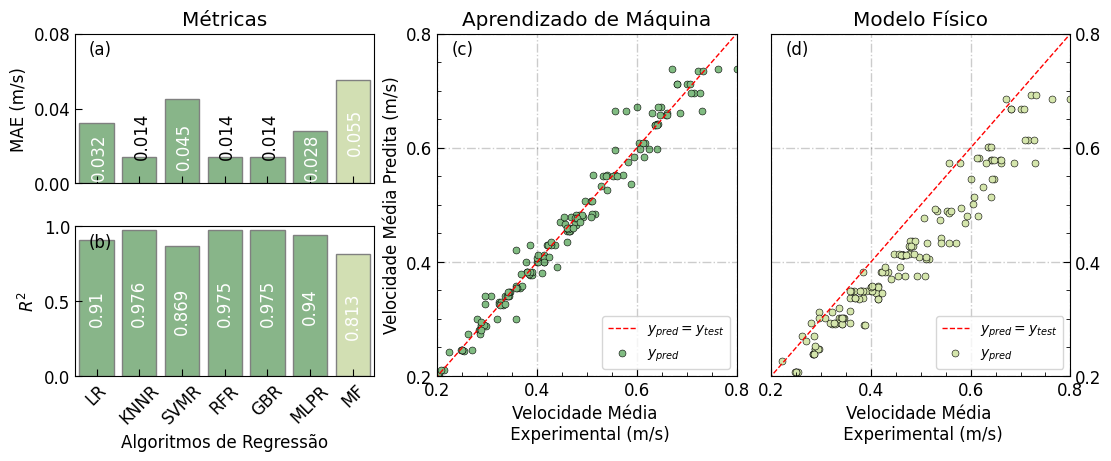

In [59]:
# Figura Regressor

# Definição dos tamanhos de fontes e ticks dos gráficos
fsize = 12
tsize = 10
major = 5.0
minor = 3.0

style = 'default'
plt.style.use(style)

#plt.rcParams['text.usetex'] = True  # Para usar fonte tex (precisa instalar o tex antes)
plt.rcParams['font.size'] = fsize      
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor


fig, axd = plt.subplot_mosaic([['(a)', '(c)', '(d)'],
                               ['(b)', '(c)', '(d)']],
                              figsize=(11, 4.5), constrained_layout=True)


# Gráficos de barras (a) e (b)
clrs = ['#81BC82' for i in regressores]+['#d5e6ac'] # Definição de cores em código hexadecimal
sns.barplot(x=list(resultados_MAE.keys()), y =[round(resultados_MAE[k],3) for k in resultados_MAE.keys()],
            ax=axd['(a)'], palette=clrs, edgecolor='grey')
sns.barplot(x=list(resultados_R2.keys()),  y =[round(resultados_R2[k],3) for k in resultados_R2.keys()],
            ax=axd['(b)'], palette=clrs, edgecolor='grey')

axd['(b)'].set_xlabel('Algoritmos de Regressão')
axd['(a)'].set_ylabel('MAE (m/s)'), axd['(a)'].set_ylim([0,0.06])
axd['(b)'].set_ylabel('$R^2$'), axd['(b)'].set_ylim([0,1])
axd['(a)'].set_yticks([0, 0.04, 0.08])
axd['(b)'].set_yticks([0, 0.5, 1])
axd['(b)'].bar_label(axd['(b)'].containers[0],  rotation=90, label_type='center', color='white')
axd['(a)'].set_title('Métricas')
plt.setp(axd['(a)'].get_xticklabels(), visible=False)
axd['(b)'].tick_params(axis='x', rotation=45)

pos=0.05
colors_mae=['w','k','w','k','k','w','w']  # Cores dos valores expressos nas barras do item (a)
y_pos_mae=[0.027,0.038,0.033,0.038,0.038,0.027,0.04] # Altura dos valores expressos nas abrras do item (a)
for i, kp in enumerate([round(resultados_MAE[k],3) for k in resultados_MAE.keys()]):       
    axd['(a)'].text(pos,y_pos_mae[i],
             s =  '{0:.3f}'.format(kp),
             color=colors_mae[i],
             rotation=90,
             horizontalalignment='center',
             verticalalignment='top',
             multialignment='center')
    pos = pos+1


# Grafico de dispersão ML
sns.scatterplot(x=y_test,y=y_pred, label='$y_{pred}$', color='#81BC82', edgecolor='k',
                marker='o', s=25, ax=axd['(c)'])
axd['(c)'].plot([0,1], [0,1], color='r', linestyle='dashed', linewidth = 1,
                  label='$y_{pred}=y_{test}$') # Reta 100% correto
axd['(c)'].set(xlabel='Velocidade Média \n Experimental (m/s)', ylabel='Velocidade Média Predita (m/s)')
axd['(c)'].legend(loc=4)
axd['(c)'].set_xlim([0.2,0.8]), axd['(c)'].set_ylim([0.2,0.8])
axd['(c)'].set_xticks([0.2, 0.4, 0.6, 0.8]), axd['(c)'].set_yticks([0.2, 0.4, 0.6, 0.8])
axd['(c)'].xaxis.set_minor_locator(AutoMinorLocator())
axd['(c)'].yaxis.set_minor_locator(AutoMinorLocator())
axd['(c)'].grid(alpha=0.2, linestyle='-.', color='k', linewidth =1)
axd['(c)'].set_title('Aprendizado de Máquina')

# Grafico de dispersão MF
sns.scatterplot(x=y_test,y=y_pred_modelo, label='$y_{pred}$', color='#d5e6ac', edgecolor='k',
                marker='o', s=25, ax=axd['(d)'])
axd['(d)'].plot([0,1], [0,1], color='r', linestyle='dashed', linewidth = 1,
                  label='$y_{pred}=y_{test}$') # Reta 100% correto
axd['(d)'].set(xlabel='Velocidade Média \n Experimental (m/s)', ylabel='Velocidade Média Predita (m/s)')
axd['(d)'].legend(loc=4)
axd['(d)'].set_xlim([0.2,0.8]), axd['(d)'].set_ylim([0.2,0.8])
axd['(d)'].set_xticks([0.2, 0.4, 0.6, 0.8]), axd['(d)'].set_yticks([0.2, 0.4, 0.6, 0.8])
axd['(d)'].xaxis.set_minor_locator(AutoMinorLocator())
axd['(d)'].yaxis.set_minor_locator(AutoMinorLocator())
axd['(d)'].grid(alpha=0.2, linestyle='-.', color='k', linewidth =1)
axd['(d)'].set_title('Modelo Físico')
axd['(d)'].yaxis.tick_right()
axd['(d)'].set_ylabel('')

# Escrevendo os itens (a), (b), ... em cada um dos gráficos da figura
for label, ax in axd.items():
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')
    
#plt.savefig("regressao.pdf", format="pdf") # Para salvar a imagem em formato pdf

### 1 - Validação cruzada

Vamos usar a validação cruzada para verificar se o desempenho de cada modelo muda com a partição de treino e teste usada.

In [60]:
x = tabela_dados[['Altura (m)','Ângulo (°)', 'objeto_aro', 'objeto_cilindro','objeto_esfera']] 
y = tabela_dados['Velocidade Média (m/s)'] # Atributo alvo

In [61]:
lr = LinearRegression()                          # Regressao Linear
knnr = KNeighborsRegressor()                     # KNN Regressor
svmr = SVR()                                     # SVM
dtr = DecisionTreeRegressor()                    # Regressão por Árvore de Decisão
rfr = RandomForestRegressor(random_state=42)     # Regressão por Random
gbr = GradientBoostingRegressor(random_state=42) # Regressão por GB
mlpr =  MLPRegressor(random_state=42)            # Multilayer Perceptron

regressores = {
    'LR':lr,
    'KNNR':knnr,
    'SVMR':svmr,
    'RFR':rfr,
    'GBR':gbr,
    'MLPR':mlpr,
    'MF':'encontra_velocidade'
}

In [64]:
# Separando 5 folds garantimos usar 20% dos dados para teste e 80% para treinamento
kf = KFold(n_splits=5, shuffle=True, random_state=42)    

results = []
for clf_name, clf in regressores.items():                       # Para cada modelo testado
    
    r2_list=[]
    mae_list=[]
    
    for i, (train_index, test_index) in enumerate(kf.split(x)): # Para cada fold de dados
        
        # Separando conjunto de treino e teste
        x_train = x.iloc[train_index]
        y_train = y.iloc[train_index]
        x_test = x.iloc[test_index]
        y_test = y.iloc[test_index]
        
        # Modelo fisico
        if clf_name == 'MF':
            y_pred = x_test.apply(lambda x: encontra_velocidade(x['Altura (m)'], x['objeto_esfera'],
                                                            x['objeto_cilindro'], x['objeto_aro']), axis=1)
            
            # Avaliando
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            # Salvando as métricas do fold
            mae_list.append(mae)
            r2_list.append(r2)
            
        # Modelos de Machine Learning
        else:
            
            # Escalonando
            scaler = MinMaxScaler()
            scaler.fit(x_train)
            x_train_scaled = scaler.transform(x_train)
            x_test_scaled = scaler.transform(x_test)

            # Treinando e predizendo
            clf.fit(x_train_scaled,y_train)
            y_pred = clf.predict(x_test_scaled)
            
            # Avaliando
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            # Salvando as métricas do fold
            mae_list.append(mae)
            r2_list.append(r2)
                
    ob = {
        'regressor':clf_name,
        'mae_avg':np.mean(mae_list),
        'mae_std':np.std(mae_list),
        'r2_avg':np.mean(r2_list),
        'r2_std':np.std(r2_list)
    }
    results.append(ob)


df_reg = pd.DataFrame(data= results)

In [65]:
df_reg.head(10)

,regressor,mae_avg,mae_std,r2_avg,r2_std
0,LR,0.032822,0.002961,0.911218,0.006541
1,KNNR,0.015638,0.001568,0.970062,0.005560
2,SVMR,0.045230,0.000747,0.866599,0.005316
3,RFR,0.014802,0.001081,0.972091,0.004699
4,GBR,0.015212,0.001373,0.972584,0.005188
5,MLPR,0.028304,0.002573,0.939298,0.012777
6,MF,0.055281,0.000726,0.801003,0.016519


<ErrorbarContainer object of 3 artists>

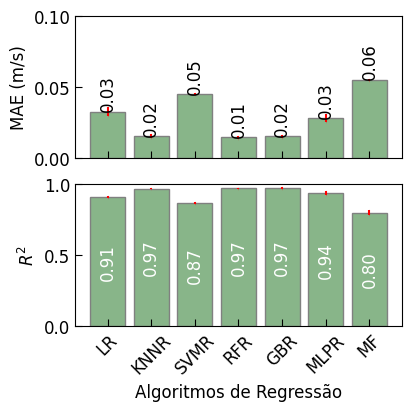

In [66]:
# Figura Validação Cruzada Classificação e Regressão
fig, axd = plt.subplot_mosaic([['(a)',],
                               ['(b)']],
                              figsize=(4, 4), constrained_layout=True)

# Gráficos de barras (c) e (d)
clrs = ['#81BC82' for i in regressores]+['#d5e6ac'] # Definição de cores em código hexadecimal
sns.barplot(x='regressor', y ='mae_avg', data=df_reg,
            ax=axd['(a)'], palette=clrs, edgecolor='grey')
sns.barplot(x='regressor',  y ='r2_avg', data=df_reg,
            ax=axd['(b)'], palette=clrs, edgecolor='grey')

axd['(a)'].set_xlabel(''),
axd['(b)'].set_xlabel('Algoritmos de Regressão')
axd['(a)'].set_ylabel('MAE (m/s)'), axd['(a)'].set_ylim([0,0.1])
axd['(b)'].set_ylabel('$R^2$'), axd['(b)'].set_ylim([0,1])
axd['(a)'].set_yticks([0, 0.05,  0.1])
axd['(b)'].set_yticks([0, 0.5, 1])
axd['(a)'].bar_label(axd['(a)'].containers[0],  rotation=90, label_type='edge', color='k', fmt='%.2f')
axd['(b)'].bar_label(axd['(b)'].containers[0],  rotation=90, label_type='center', color='white', fmt='%.2f')


plt.setp(axd['(a)'].get_xticklabels(), visible=False)
axd['(b)'].tick_params(axis='x', rotation=45)


# Barras verticais indicando variabilidade pelo desvio padraõ
x_coords = [p.get_x() + 0.5 * p.get_width() for p in axd['(a)'].patches]
y_coords = [p.get_height() for p in axd['(a)'].patches]
axd['(a)'].errorbar(x=x_coords, y=y_coords, yerr=df_reg['mae_std'], fmt="none", c="r", capsize=0.1)

x_coords = [p.get_x() + 0.5 * p.get_width() for p in axd['(b)'].patches]
y_coords = [p.get_height() for p in axd['(b)'].patches]
axd['(b)'].errorbar(x=x_coords, y=y_coords, yerr=df_reg['r2_std'], fmt="none", c="r", capsize=0.1)


#plt.savefig("regressao.pdf", format="pdf") # Para salvar a imagem em formato pdf